In [463]:
from sklearn.base import BaseEstimator, TransformerMixin
#https://github.com/mwv/zca
from zca.zca import zca
import pandas as pd
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import scipy
import numpy as np
import scipy.stats as st
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV

In [464]:
class ss_yj_Transformer(BaseEstimator, TransformerMixin):
    # add another additional parameter, just for fun, while we are at it
    
    def __init__(self, feature_names=[], additional_param = ""):  
        self.ss_X = StandardScaler()
        self.pt_X = PowerTransformer(standardize=True)
        self.zca_X = zca.ZCA()
        self.ss_y = StandardScaler()
        self.pt_y = PowerTransformer(standardize=True)  
        self.zca_y = zca.ZCA()
        self.feature_names = feature_names
        self.additional_param = additional_param
        self.medians = pd.DataFrame()
        self.mads = []
        self.mad_transformed = pd.DataFrame()

    def fit(self, X, y = None):
        self.ss_X.fit(X)
        self.medians = X.median()
        self.mads = pd.DataFrame(scipy.stats.median_abs_deviation(X,scale='normal'),index=X.columns).T#scipy.stats.median_abs_deviation(X)
        #self.pt_X.fit(self.ss_X.transform(X))
        self.mad_transformed = ((X-X.median())/scipy.stats.median_abs_deviation(X,scale='normal'))
        self.pt_X.fit(self.mad_transformed)        
        self.zca_X.fit(self.pt_X.transform(self.ss_X.transform(X)))
        if (y is not None):
            self.ss_y.fit(y)
            self.pt_y.fit(self.ss_y.transform(y))
            self.zca_y.fit(self.pt_y.transform(self.ss_y.transform(y)))
        return self

    def transform(self, X, y = None):
        #pt_X_ = pd.DataFrame(self.zca_X.fit_transform(self.pt_X.fit_transform(self.ss_X.fit_transform(X))),columns=X.columns,index=X.index)
        #pt_X_ = pd.DataFrame(self.zca_X.fit_transform(self.pt_X.fit_transform(self.mad_transformed)),columns=X.columns,index=X.index)
        pt_X_ = pd.DataFrame(self.zca_X.fit_transform(self.pt_X.fit_transform(self.mad_transformed)),columns=X.columns)
        if (y is None):
            return pt_X_
        else:
            pt_y_ = pd.DataFrame(self.zca_y.fit_transform(self.pt_y.fit_transform(self.ss_y.fit_transform(X))),columns=Y.columns,index=Y.index)
            return pt_X_, pt_y_
        
    def inverse_transform(self, X, y = None):
        #target_X = pd.DataFrame(self.ss_X.inverse_transform(self.pt_X.inverse_transform(self.zca_X.inverse_transform(X))),index=X.index,columns=X.columns)
        target_X = pd.DataFrame((self.pt_X.inverse_transform(self.zca_X.inverse_transform(X))),columns=X.columns)*np.array(self.mads)+np.array(self.medians)
        if (y is None):
            return target_X
        else:
            target_y = pd.DataFrame(self.ss_Xy.inverse_transform(self.pt_y.inverse_transform(self.zca_y.inverse_transform(y))),index=y.index,columns=y.columns)
            return target_X, target_y
        
def ecdf2(values):
        co = len(values)
        externalArray = pd.DataFrame()
        for d in range(0,len(values.columns)):
            internalArray = []
            for i in range(0,len(values.iloc[:,d])):
                a = ( \
                    sum( ( values.iloc[:,d] <= values.iloc[:,d][i] ) ) + \
                    sum( ( values.iloc[:,d] <  values.iloc[:,d][i] ) ) \
                    ) / 2 / co
                internalArray.append(a)

            externalArray = pd.concat([externalArray,pd.DataFrame(internalArray).round(2)],axis=1)
            externalArray.columns = values.columns
            externalArray.index = values.index

        return(externalArray)        

In [465]:
exclude = 'States'

In [466]:
bandwidths = np.linspace(1.0, 1.2, 10)

In [467]:
bandwidths

array([1.        , 1.02222222, 1.04444444, 1.06666667, 1.08888889,
       1.11111111, 1.13333333, 1.15555556, 1.17777778, 1.2       ])

In [468]:
all_data = pd.read_csv('../data/raw/states.csv')

X = all_data[set(all_data.columns).difference([exclude])].copy()
display(X.describe())
X.index=all_data[exclude]
display(X)

,Doctors,Traf Deaths,Crime,Unemployed,Income,University,Poverty,Infant Mort,White,Population
count,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,5.000000e+01
mean,260.276000,1.40440,407.480000,5.270000,51985.100000,26.940000,12.732000,6.830000,81.96200,6.016154e+06
std,64.363415,0.38654,183.633868,1.253933,8592.657934,4.761152,2.939002,1.338786,11.97458,6.663772e+06
min,168.800000,0.76000,118.000000,3.000000,37790.000000,17.100000,7.600000,4.700000,29.70000,5.232260e+05
25%,218.425000,1.14000,278.250000,4.400000,46161.250000,24.025000,10.450000,5.725000,76.15000,1.779632e+06
50%,249.050000,1.37500,345.500000,5.300000,50173.000000,26.200000,12.400000,6.850000,84.55000,4.313980e+06
75%,274.800000,1.62000,520.000000,6.275000,56903.000000,29.825000,14.700000,7.750000,89.85000,6.490796e+06
max,469.000000,2.45000,788.000000,8.400000,70545.000000,38.100000,21.200000,10.600000,96.40000,3.618591e+07


,Doctors,Traf Deaths,Crime,Unemployed,Income,University,Poverty,Infant Mort,White,Population
States,,,,,,,,,,
Alabama,218.2,1.81,448,5.0,42666,22.0,15.7,9.0,71.0,4634063
Alaska,228.5,1.63,661,6.7,68460,27.3,8.4,6.9,70.6,679893
Arizona,209.7,1.69,483,5.5,50958,25.1,14.7,6.4,86.5,6360238
Arkansas,203.4,1.96,529,5.1,38815,18.8,17.3,8.5,80.8,2841595
California,268.7,1.21,523,7.2,61021,29.6,13.3,5.0,76.6,36185908
Colorado,259.7,1.14,348,4.9,56993,35.6,11.4,5.7,89.7,4837229
Connecticut,376.4,0.86,256,5.7,68595,35.6,9.3,6.2,84.3,3488084
Delaware,250.9,1.23,689,4.8,57989,27.5,10.0,8.3,74.3,865314
Florida,247.9,1.56,723,6.2,47778,25.8,13.2,7.3,79.8,18262096


,Doctors,Traf Deaths,Crime,Unemployed,Income,University,Poverty,Infant Mort,White,Population
count,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01
mean,-8.881784e-18,-5.329071e-17,8.326673e-17,8.881784e-18,3.552714e-17,-3.552714e-17,-7.549517e-17,-2.886580e-17,-2.664535e-17,-4.884981e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.352371e+00,-1.914266e+00,-1.981415e+00,-1.627159e+00,-1.788511e+00,-2.656435e+00,-1.920661e+00,-2.091258e+00,-3.965103e+00,-2.142666e+00
25%,-5.097175e-01,-7.295234e-01,-6.550302e-01,-7.560676e-01,-9.075949e-01,-4.998651e-01,-7.501128e-01,-8.888642e-01,-6.088201e-01,-6.638030e-01
50%,9.250486e-02,2.781613e-02,-1.611392e-01,5.597115e-02,2.008025e-02,2.945141e-02,7.586969e-03,1.686568e-01,9.523894e-02,7.985929e-02
75%,5.762914e-01,4.932323e-01,6.527081e-01,6.384850e-01,8.136427e-01,6.056981e-01,7.587009e-01,8.147284e-01,6.184801e-01,6.181143e-01
max,1.712015e+00,3.694339e+00,2.249081e+00,2.281258e+00,1.833320e+00,2.605767e+00,2.264157e+00,1.771269e+00,1.566087e+00,1.970986e+00


Doctors       -2.352371
Traf Deaths   -1.914266
Crime         -1.981415
Unemployed    -1.627159
Income        -1.788511
University    -2.656435
Poverty       -1.920661
Infant Mort   -2.091258
White         -3.965103
Population    -2.142666
dtype: float64

Doctors        1.712015
Traf Deaths    3.694339
Crime          2.249081
Unemployed     2.281258
Income         1.833320
University     2.605767
Poverty        2.264157
Infant Mort    1.771269
White          1.566087
Population     1.970986
dtype: float64

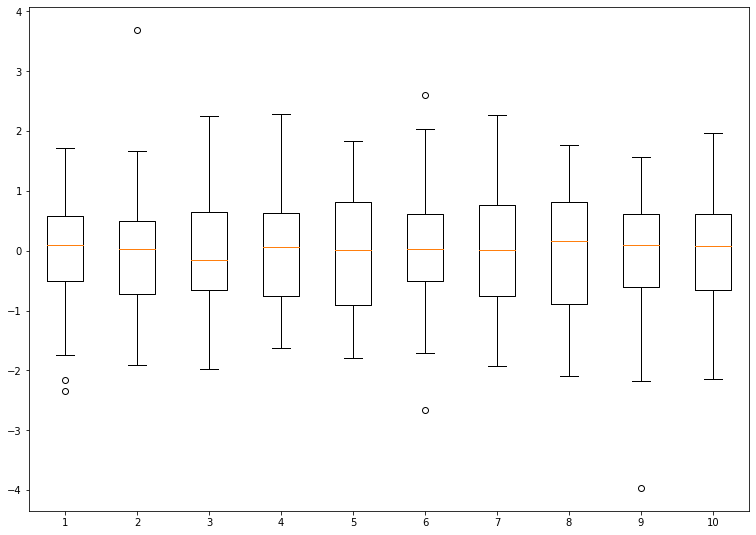

In [469]:
scaler = ss_yj_Transformer()
scaler.fit(X)
X_ = scaler.transform(X)
X_.index=all_data[exclude]
#display(X_)
display(X_.describe())
display(X_.min())
display(X_.max())
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(X_)

In [ ]:
raw_pct.columns = X.columns
kde_pct.columns = X.columns

In [ ]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(kde_pct)

In [ ]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(raw_pct)

In [ ]:
random_ = pd.DataFrame(np.random.rand(10000,10),columns=X.columns)*(kde_pct.max()-kde_pct.min())+kde_pct.min()
#random_ = pd.DataFrame(np.random.rand(10000,10),columns=X.columns)*(raw_pct.max()-raw_pct.min())+raw_pct.min()
random_set = scaler.inverse_transform(pd.DataFrame(st.norm.ppf(random_),columns=X_.columns)).describe()


In [ ]:
random_set.describe()

In [ ]:
#old = pd.DataFrame(areas).shift(-1).replace([np.inf, -np.inf, np.NaN], 0)
#add = (pd.DataFrame(areas).diff().replace([np.inf, -np.inf, np.NaN], 0)/2)
#add
diff = pd.DataFrame(areas).diff().replace([np.inf, -np.inf, np.NaN], 0)
#old + (diff/2)
plt.plot(areas)

In [ ]:
X_['Poverty'].sort_values(kind="quicksort", ascending=True,key=abs)

In [461]:
from scipy.integrate import simps
from numpy import trapz

import numpy as np

x = raw_pct['Poverty'].sort_values(kind="quicksort", ascending=True,key=abs)
y = np.repeat(1, len(x), axis = 0).reshape(-1,1).ravel()

print(x)
print(y)

fullArea = trapz(y,x,dx=.01)
areas = []
for i in range(1,len(x)+1):
    subarea = trapz(y[0:i],x[0:i],dx=.01)/fullArea
    areas.append(subarea)

print(fullArea)

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x, y)

logprobX = (pd.DataFrame(areas).shift(1).replace([np.inf, -np.inf, np.NaN], 0)+pd.DataFrame(areas))/2
logprobX.index = x.index

plt.show()
plt.plot(pd.DataFrame(logprobX))
display(pd.DataFrame(logprobX))

#

KeyError: 'Poverty'

In [ ]:
X[['Poverty']]

In [ ]:
import scipy.stats as st

In [ ]:
newS = StandardScaler()
data = X[['Poverty']]
newS.fit(data)
#newS.fit_transform(data).ravel()
scaled_Poverty = pd.DataFrame(newS.fit_transform(data).ravel(),columns=['Poverty'],index=X.index)

In [ ]:
plt.scatter(ecdf2(X[['Poverty']].sort_values(kind="quicksort", by='Poverty', ascending=True,key=abs)), pd.DataFrame(st.norm.cdf(scaled_Poverty),columns=['Poverty'],index=X.index).sort_values(kind="quicksort", by='Poverty', ascending=True))

In [ ]:
scipy.stats.median_abs_deviation

median_scaled = pd.DataFrame(st.norm.cdf(((X-X.median())/scipy.stats.median_abs_deviation(X,scale='normal'))),columns=X.columns,index=X.index)

mean_scaled = pd.DataFrame(st.norm.cdf((X-X.mean())/np.std(X)),columns=X.columns,index=X.index)

In [ ]:
new_scale = (mean_scaled+mean_scaled)/2
new_scale.hist()
plt.show()
print(new_scale.mean())

display(new_scale.describe())

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(new_scale)



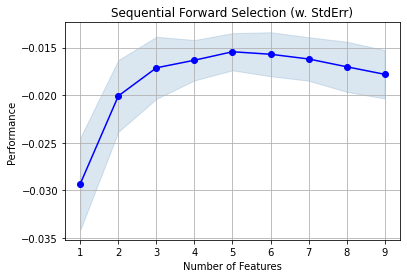

In [460]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston

lr = LinearRegression()

target = 'Poverty'
sfs = sfs(lr, 
    k_features=len(new_scale.columns)-1, 
    forward=True, 
    floating=False, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=10)

sfs = sfs.fit(new_scale.loc[:, ~new_scale.columns.isin([target])], pd.DataFrame(new_scale[target]))
fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [ ]:
x = ecdf2(X[['Poverty']]).sort_values(kind="quicksort", by='Poverty', ascending=True)
x = median_scaled[['Poverty']].sort_values(kind="quicksort", by='Poverty', ascending=True)
y = pd.DataFrame(st.norm.cdf(scaled_Poverty),columns=['Poverty'],index=X.index).sort_values(kind="quicksort", by='Poverty', ascending=True)

In [ ]:
#trapz(np.array(y),np.array(x))
trapz(y,x,dx=.01)
#np.sum(fullArea)

In [ ]:
import seaborn as sns
#plot_ = plt.scatter(x, y)
temp = pd.concat([x,y],axis=1)
temp.columns=['Poverty'+str(" MAD CDF"),'Poverty'+str(" STD CDF")]
temp.plot('Poverty'+str(" MAD CDF"),'Poverty'+str(" STD CDF"))
#temp
#ax = sns.scatterplot(data=temp, x='Poverty'+str(" MAD CDF"), y='Poverty'+str(" STD CDF"))
#sns.set_xlabel(temp.index)
#ax.set_xlabel('Poverty'+str(" MAD CDF"))
#plt.plot()
#plot_.set_label(x.index)
#x_ticks = x.index
#dir(plot_)
#set_xticks(X.index)
#plot.set_xticklabels(X.index)
#plt.xticks(rotation = 45)

labels = temp.index

plt.figure(figsize=[8,8])

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    temp['Poverty'+str(" MAD CDF")], temp['Poverty'+str(" STD CDF")], marker='o')#, c=data[:, 2], s=data[:, 3] * 1500,
    #cmap=plt.get_cmap('Spectral'))

for label, x_, y_ in zip(labels, temp['Poverty'+str(" MAD CDF")], temp['Poverty'+str(" STD CDF")]):
    plt.annotate(
        label,
        xy=(x_, y_), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        #bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        size=9,
        rotation=-45,
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.show()
'''

temp.plot('Poverty'+str(" MAD CDF"),'Poverty'+str(" STD CDF"))
plt.show()
df = temp.reset_index()
df = df.rename(columns={"index":"State"})
#df
ax = df.plot('Poverty'+str(" MAD CDF"),'Poverty'+str(" STD CDF"),kind='scatter',rot=90)
#ax.set_xticklabels(df["index"]);
plt.show()
plt.plot(temp.mean(axis=1))
plt.xticks(rotation = 90,size=8)
'''

In [ ]:
from scipy.integrate import simps
from numpy import trapz

import numpy as np

def function(x):
    return x**2

#x = [1,2,4]
#y = [1,1,2]

#print(x)
#print(y)

# primitive :

#print("area: ", 1.0 / 3.0 * ( x[len(x)-1]**3 - x[0]**3 ))

# using Trapezoidal rule:

fullArea = trapz((y).values.ravel(),(x).values.ravel())
print(fullArea)

areas = []
for i in range(1,len(x)+1):
    subarea = trapz((y).values.ravel()[0:i],(x).values.ravel()[0:i])/fullArea
    areas.append(subarea)

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x, y)

axes = plt.gca()
m, b = np.polyfit((x).values.ravel(),(y).values.ravel(), 1)
new_values = m*x + b
X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-')

plt.show()

#plt.plot(new_values)
#plt.show()
plt.plot(pd.DataFrame(areas))
#display(pd.DataFrame(areas))
plt.show()

bandwidths = np.linspace(.001, 5, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths},
                        )

kde_pct = pd.DataFrame()
raw_pct = pd.DataFrame()

#for i in X.columns:
print(i)
og = temp.mean(axis=1).sort_values(kind="quicksort",ascending=True)
og_pct = og
#og_pct = pd.DataFrame(st.norm.cdf(og),index=og.index)
plt.plot(og_pct)
plt.xticks(rotation = 90,size=8)
grid.fit(np.array(og_pct).reshape(-1,1))
print("bandwidth: " + str(grid.best_params_['bandwidth']))
kde = KernelDensity(bandwidth=grid.best_params_['bandwidth'], kernel='gaussian')
kde.fit(np.array(og_pct).reshape(-1,1))
logprobX = np.cumsum(np.exp(kde.score_samples(np.array(og_pct).reshape(-1,1))))/np.sum(np.exp(kde.score_samples(np.array(og_pct).reshape(-1,1))))
logprobX = (pd.DataFrame(logprobX).shift(1).replace([np.inf, -np.inf, np.NaN], 0)+pd.DataFrame(logprobX))/2
logprobX.index = og.index
kde_pct = pd.concat([kde_pct,logprobX],axis=1)
raw_pct = pd.concat([raw_pct,og_pct],axis=1)
plt.plot(logprobX)
plt.show()
display(st.norm.ppf(logprobX)[0])
display(st.norm.ppf(logprobX)[len(logprobX)-1])
#display(X_[[i]].min())
#display(X_[[i]].max())

logprobX.mean()

coefficients  = np.polyfit(x['Poverty'],y['Poverty'], deg=3,)
print(coefficients)
poly = np.poly1d(coefficients)
new_x = np.linspace((x).values.ravel()[0], (x).values.ravel()[-1])
new_y = poly(new_x)
plt.plot((x).values.ravel(), (y).values.ravel(), "o", new_x, new_y)
plt.show()
plt.plot(pd.DataFrame(new_y,index=x.index),linestyle='--', marker='o', color='b')
plt.xticks(rotation = 90,size=8)
#plt.xlim([(x).values.ravel()[0]-1, (y).values.ravel()[-1] + 1 ])
display(pd.DataFrame(new_y,index=x.index))
#plt.savefig("line.jpg")
#X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1])
#plt.plot(X_plot, m*X_plot + b, '-')

In [ ]:
plt.plot(temp.mean(axis=1))

In [ ]:
from scipy.integrate import simps
from numpy import trapz

import numpy as np

#x = [1,2,4]
#y = [1,1,2]

print(x)
print(y)

# primitive :

#print("area: ", 1.0 / 3.0 * ( x[len(x)-1]**3 - x[0]**3 ))

# using Trapezoidal rule:


areas = []
for i in range(1,len(x)+1):
    subarea = trapz(y[0:i],x[0:i])/fullArea
    areas.append(subarea)

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(x, y)

plt.show()
plt.plot(pd.DataFrame(areas))
display(pd.DataFrame(areas))

In [ ]:
dataset = pd.DataFrame()

for p in range(0,1000):
    row = list()
    indices = np.random.choice(raw_pct.shape[0], size=len(raw_pct.columns))
    for i in range(0,len(raw_pct.columns)):
        row.append(raw_pct[[raw_pct.columns[i]]].iloc[indices[i]][0])
        #print()
        
    data = pd.DataFrame(row).T
    data.columns = raw_pct.columns    

    dataset = pd.concat([dataset,data],axis=0)
    
scaler.inverse_transform(pd.DataFrame(st.norm.ppf(dataset),columns=data.columns)).describe()

In [ ]:
scaler.inverse_transform(random_).describe()

In [ ]:
display(X_.min())
display(X_.max())

In [ ]:
testzca = zca.ZCA()
testzca.fit(X)
testzca_X = pd.DataFrame(testzca.transform(X),index=all_data[exclude],columns=X.columns)

In [ ]:
#here I impute new values into the "random noise", aka whitened matrix
test1 = testzca_X.loc[['New Mexico']]
test2 = testzca_X.loc[['New Mexico']]
test3 = testzca_X.loc[['New Mexico']]

In [ ]:
test1['Crime']=testzca_X['Crime'].describe()['25%']
test2['Crime']=0
test3['Crime']=testzca_X['Crime'].describe()['75%']

In [ ]:
display(scaler.inverse_transform(test1))
display(scaler.inverse_transform(test2))
display(scaler.inverse_transform(test3))

In [ ]:
#here I impute new values into the "random noise", aka whitened matrix
test4 = X_.loc[['Alaska']]
test5 = X_.loc[['Alaska']]
test6 = X_.loc[['Alaska']]

In [ ]:
test4['Crime']=X_['Crime'].min()
test5['Crime']=0
test6['Crime']=X_['Crime'].max()

In [ ]:
display(scaler.inverse_transform(test4))
display(scaler.inverse_transform(test5))
display(scaler.inverse_transform(test6))

In [ ]:
scaler.inverse_transform(pd.DataFrame(np.zeros(shape=(1,len(X.columns))),columns=X.columns))

In [ ]:
scaler.inverse_transform(X_).describe()

In [ ]:
X_.hist()

In [ ]:
scaler.inverse_transform(X_).describe()